# TikTok data and LLM coding

### Setup 

Run the following cells to set up this notebook

In [2]:
from IPython.display import display, clear_output
import json
from ipywidgets import widgets, VBox, HBox, Button, Label, Output
import krippendorff
import pandas as pd
import pyktok as pyk
import random
from openai import OpenAI
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

_ = load_dotenv("../01_Introduction_and_Setup/.env")

In [3]:
client = OpenAI()

In [4]:
import nest_asyncio
nest_asyncio.apply()

## Exploring Public Opinion in TikTok Comments

This week we will be exploring TikTok's role in shaping public opinion. Social media has become a popular site of discourse, and platforms like TikTok have been credited for shaping popular culture, politics, and everyday interactions. TikTok comment sections are a site where public opinion is debated and negotiated. At the same time, platform-level decisions alter what comments are most visible on comment pages.

## Choosing a Debate

Create a group of 2 (where at least one person in the group has a TikTok account) and find a video related to popular culture that has discusses two clearly defined positions as a part of a greater debate. This video should also have at least 10k comments. Copy the url of the video and paste it below.

In [5]:
# Replace with your video URL
video_url = "https://www.tiktok.com/@nick.digiovanni/video/6915887479237266694"

## Scrape Comments!

In [27]:
async def get_comments():
    pyk.save_tiktok_comments(video_url,
                         comment_count=1000,
                         save_comments=True,
                         return_comments=False,)

await get_comments()

1002 comments saved.


## Define a Research Question
What are you hoping to learn by studying comments on this video?

Is popcorn chicken favored over popcorn in the selected comments?

## Defining Concepts
Quantitative content analysis is a popular method for translating non-numeric content into numeric, quantitative data. To do so, researchers create clearly defined and validated concepts. The first step in studying our TikTok debate is clearly defining how each position should be coded.

In [11]:
# Requests for other videos are not considered as belonging to either concept
# If it is unclear whether or not something is positive or negative, please don't mark either concept (mentioning dents in a cutting board)
# If a question is posed pertaining to these concepts, mark none
# If a comment is incomplete, do not make assumptions on how to interpret it
# These are the iterated concepts
concept1 = """
A negative reaction to the video and/or the topic of popcorn chicken. This includes equating popcorn chicken to chicken nuggets,
argues about a flaw in the video or dismisses the concept, or favors popcorn (mentioned in the description)
"""

concept2 = """
A positive reaction to the video and/or the topic of popcorn chicken. This includes aligning with the sauce choice in the video, mentioning 
liking popcorn chicken, or mentioning another Tiktok user.
"""

## Let's Code!

In [9]:
# !!Replace with your filename!!
df = pd.read_csv('@nick.digiovanni_video_6915887479237266694_comments.csv') 

sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)
text_col = 'text'

for col in ['coder1_concept1', 'coder1_concept2', 'coder2_concept1', 'coder2_concept2']:
    sample_df[col] = None

main_out = Output()
coder1_out = Output()
coder2_out = Output()

def code_entries(coder_label, concept1_col, concept2_col, container_out, next_callback=None):
    index = 0
    text_label = Label(value=sample_df.loc[index, text_col])

    # !!Change the descriptions to your concepts!!
    concept1 = widgets.ToggleButtons(options=[0, 1], description='Concept 1:')
    concept2 = widgets.ToggleButtons(options=[0, 1], description='Concept 2:')
    
    next_button = Button(description='Next →', button_style='success')
    progress = Label(value=f"{coder_label}: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, concept1_col] = concept1.value
        sample_df.loc[index, concept2_col] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"{coder_label}: {index + 1}/{len(sample_df)}"
        else:
            container_out.clear_output()
            with container_out:
                display(Label(value=f"{coder_label} has finished coding! ✅"))
                if next_callback:
                    next_callback()
                else:
                    with main_out:
                        print("✅ Both coders finished. Saving data...")
                        sample_df.to_csv('coded_data.csv', index=False)
                        print("💾 Coded data saved to coded_data.csv")

    next_button.on_click(next_entry)

    with container_out:
        container_out.clear_output()
        display(VBox([progress, text_label, concept1, concept2, next_button]))

# ---- Workflow ----

def start_coder2():
    print("\n=== Coder 2: Please start coding ===")
    code_entries("Coder 2", "coder2_concept1", "coder2_concept2", coder2_out)

print(f"Concept 1: {concept1}")
print(f"Concept 2: {concept2}\n")

print("=== Coder 1: Please start coding ===")
code_entries("Coder 1", "coder1_concept1", "coder1_concept2", coder1_out, next_callback=start_coder2)

display(coder1_out, coder2_out, main_out)


Concept 1: 
A negative reaction to the video and/or the topic of popcorn chicken. This includes equating popcorn chicken to chicken nuggets,
argues about a flaw in the video or dismisses the concept, or favors popcorn (mentioned in the description)

Concept 2: 
A positive reaction to the video and/or the topic of popcorn chicken. This includes aligning with the sauce choice in the video, mentioning 
liking popcorn chicken, or mentioning another Tiktok user.


=== Coder 1: Please start coding ===


Output()

Output()

Output()

## Assess Interrater Reliability

In [10]:
df = pd.read_csv("coded_data.csv")

def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        df[f'coder1_{concept_name}'].tolist(),
        df[f'coder2_{concept_name}'].tolist()
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

alpha_concept1 = krippendorff_alpha_for_concept(df, "concept1")
alpha_concept2 = krippendorff_alpha_for_concept(df, "concept2")

print("Krippendorff’s Alpha Scores:")
print(f"• Concept 1: {alpha_concept1:.3f}")
print(f"• Concept 2: {alpha_concept2:.3f}")

Krippendorff’s Alpha Scores:
• Concept 1: 0.960
• Concept 2: 1.000


## Evaluate the interrater reliability and iterate!

![](krippendorff.png)

Describe your interrater reliability. If you scored high, great! How did your concept descriptions help you code effectively? If you scored poorly, what might you have done better?

**Regardless of your score, discuss potential edge cases and improve your concept descriptions**

I think some issues could be with how vague we were with our concepts. I think more detailed descriptions of the concepts would allow us to make better judgements at each step and improve the strength of agreement between us.

Two better concepts could be:
- Select this concept if popcorn chicken is not favored or compared to a chicken nugget.
- Select this concept if popcorn chicken is favored by this comment, or sauces are mentioned that are relevant to the video.
I think also providing guidelines on each concept, especially in prompting, will be super helpful.

## Hire a LLM coder!
Write a prompt for an LLM to code the same 100 comments and calculate intercoder reliability. Be sure to tell the LLM their role!

In [33]:
LLM_prompt = f'''
You are a research assistant performing a quantitative coding task. 
You will receive a series of comments on a TikTok short video recipe for popcorn chicken from the Nick DiGiovanni channel.
You are given the following concepts:

Concept 1: {concept1}
Concept 2: {concept2}
Requests for other videos are not considered as belonging to either concept
'''
print(LLM_prompt)


You are a research assistant performing a quantitative coding task. 
You will receive a series of comments on a TikTok short video recipe for popcorn chicken from the Nick DiGiovanni channel.
You are given the following concepts:

Concept 1: 
A negative reaction to the video and/or the topic of popcorn chicken. This includes equating popcorn chicken to chicken nuggets,
argues about a flaw in the video or dismisses the concept, or favors popcorn (mentioned in the description)

Concept 2: 
A positive reaction to the video and/or the topic of popcorn chicken. This includes aligning with the sauce choice in the video, mentioning 
liking popcorn chicken, or mentioning another Tiktok user.

Requests for other videos are not considered as belonging to either concept



## Code with your LLM coder!
For the human coding, agree on a code with your partner for each of the concept

In [34]:
df = pd.read_csv('@nick.digiovanni_video_6915887479237266694_comments.csv') 

sample_df = df.sample(n=100, random_state=42).reset_index(drop=True)

In [39]:
text_col = "text"

sample_df["human_concept1"] = None
sample_df["human_concept2"] = None

def code_entries():
    index = 0
    out = Output()

    text_label = widgets.Textarea(value=sample_df.loc[index, text_col], layout=widgets.Layout(width='600px', height='120px'))
    concept1 = widgets.ToggleButtons(options=[0, 1], description="Concept 1:")
    concept2 = widgets.ToggleButtons(options=[0, 1], description="Concept 2:")
    next_button = Button(description="Next →", button_style="success")
    progress = Label(value=f"Human Coding: {index + 1}/{len(sample_df)}")

    def next_entry(_):
        nonlocal index
        sample_df.loc[index, "human_concept1"] = concept1.value
        sample_df.loc[index, "human_concept2"] = concept2.value

        index += 1
        if index < len(sample_df):
            text_label.value = sample_df.loc[index, text_col]
            concept1.value = None
            concept2.value = None
            progress.value = f"Human Coding: {index + 1}/{len(sample_df)}"
        else:
            clear_output()
            display(Label(value="✅ Human coding complete! Now AI will code the same sample."))
            out.clear_output()

    next_button.on_click(next_entry)
    display(VBox([progress, text_label, concept1, concept2, next_button, out]))

code_entries()


In [35]:
batch_size = 10

def prompt_creator(text_list, texts_formatted, extra_instructions): 
    return f"""
        {LLM_prompt}
        
        You will receive {len(text_list)} texts.
        
        Return ONLY valid JSON — a list of {len(text_list)} dictionaries like this:
        
        [
          {{"concept1": 1, "concept2": 0}},
          ...
        ]
        
        No explanations, no comments, no extra text — only the JSON array. Do not add extra formatting. {extra_instructions}
        
        Texts:
        {texts_formatted}
    """

def ai_code_batch(text_list):
    texts_formatted = "\n".join([f"{i+1}. {t}" for i, t in enumerate(text_list)])
    
    prompt = prompt_creator(text_list, texts_formatted, "")

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    try:
        output_text = response.choices[0].message.content.strip()
        batch_json = json.loads(output_text)
        return batch_json  
    except Exception as e:
        try:
            print("Trying to parse")
            s = output_text.replace("```", "").replace("json", "").replace("\n", "").strip()
            lst = json.loads(s)
            print("✅ Parsed successfully.")
            return lst
        except Exception as e:
            print("Parsing error:", e)
            print("Model output:", output_text)
            return [{"concept1": None, "concept2": None} for _ in text_list]

In [36]:
sample_ai_concept1, sample_ai_concept2 = [], []

for start in range(0, len(sample_df), batch_size):
    print(f"Beginning coding round {start//batch_size}")
    end = start + batch_size
    sample_batch_texts = sample_df[text_col].iloc[start:end].tolist()
    sample_batch_results = ai_code_batch(sample_batch_texts)

    for r in sample_batch_results:
        sample_ai_concept1.append(r.get("concept1"))
        sample_ai_concept2.append(r.get("concept2"))

sample_df["ai_concept1"] = sample_ai_concept1
sample_df["ai_concept2"] = sample_ai_concept2

sample_df.to_csv("ai_coded_data.csv", index=False)
print("✅ Combined human + AI coded data saved to ai_coded_data.csv")


Beginning coding round 0
Beginning coding round 1
Beginning coding round 2
Beginning coding round 3
Beginning coding round 4
Beginning coding round 5
Beginning coding round 6
Beginning coding round 7
Beginning coding round 8
Beginning coding round 9
✅ Combined human + AI coded data saved to ai_coded_data.csv


## Evaluate your agreement
Repeat the process until you reach at least 0.7 agreeability with the LLM

In [77]:
def krippendorff_alpha_for_concept(df, concept_name):
    data = [
        [i if i else 0 for i in df[f"human_{concept_name}"].tolist()],
        [i if i else 0 for i in df[f"ai_{concept_name}"].tolist()]
    ]
    return krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')

sample_df = pd.read_csv('ai_coded_data.csv') 

alpha_c1 = krippendorff_alpha_for_concept(sample_df, "concept1")
alpha_c2 = krippendorff_alpha_for_concept(sample_df, "concept2")

print("Krippendorff’s Alpha between Human and AI:")
print(f"• Concept 1: {alpha_c1:.3f}")
print(f"• Concept 2: {alpha_c2:.3f}")


Krippendorff’s Alpha between Human and AI:
• Concept 1: 0.730
• Concept 2: 0.759


## Use your prompt to code the entire comments dataset

In [82]:
comments = pd.read_csv("@nick.digiovanni_video_6915887479237266694_comments.csv")

ai_concept1, ai_concept2 = [], []

batch_size = 50

for start in range(0, len(comments), batch_size):
    print(f"Beginning coding round {(start//batch_size) + 1}")
    
    end = min(start + batch_size, len(comments))
    batch_texts = comments[text_col].iloc[start:end].tolist()
    
    batch_results = ai_code_batch(batch_texts)

    if len(batch_results) != len(batch_texts):
        batch_results = batch_results[:len(batch_texts)]

    for r in batch_results:
        ai_concept1.append(r.get("concept1"))
        ai_concept2.append(r.get("concept2"))

Beginning coding round 1
Beginning coding round 2
Beginning coding round 3
Beginning coding round 4
Beginning coding round 5
Beginning coding round 6
Beginning coding round 7
Beginning coding round 8
Beginning coding round 9
Beginning coding round 10
Beginning coding round 11
Beginning coding round 12
Beginning coding round 13
Beginning coding round 14
Beginning coding round 15
Beginning coding round 16
Beginning coding round 17
Beginning coding round 18
Beginning coding round 19
Beginning coding round 20


In [83]:
# Add results to dataframe
comments["ai_concept1"] = ai_concept1
comments["ai_concept2"] = ai_concept2

# Save to file
comments.to_csv("final_coded_data.csv", index=False)
print("✅ Finished Coding!")

✅ Finished Coding!


## Analyze your data

In [84]:
final_coded_data = pd.read_csv("final_coded_data.csv")

#### Exploring quantity of comments

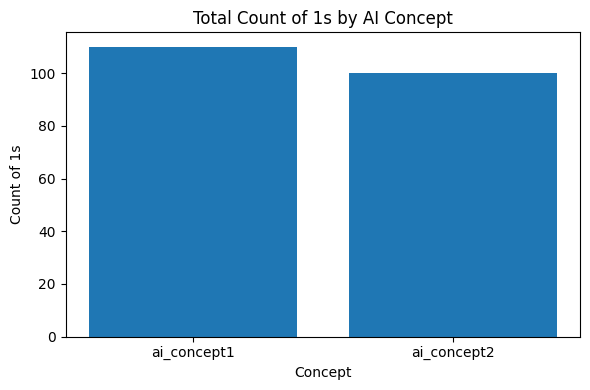

In [85]:
counts = {
    "ai_concept1": final_coded_data["ai_concept1"].sum(),
    "ai_concept2": final_coded_data["ai_concept2"].sum()
}

count_df = pd.DataFrame(list(counts.items()), columns=["Concept", "Total_1s"])

plt.figure(figsize=(6, 4))
plt.bar(count_df["Concept"], count_df["Total_1s"])
plt.title("Total Count of 1s by AI Concept")
plt.ylabel("Count of 1s")
plt.xlabel("Concept")
plt.tight_layout()
plt.show()

#### What comments received more likes?

In [86]:
def collapse(x):
    if x.ai_concept1 == 1:
        return "concept1"
    elif x.ai_concept2 == 1:
        return "concept2"
    else:
        return "neither"

final_coded_data['collapsed_codes'] = final_coded_data.apply(collapse, axis=1)

<Axes: xlabel='digg_count', ylabel='collapsed_codes'>

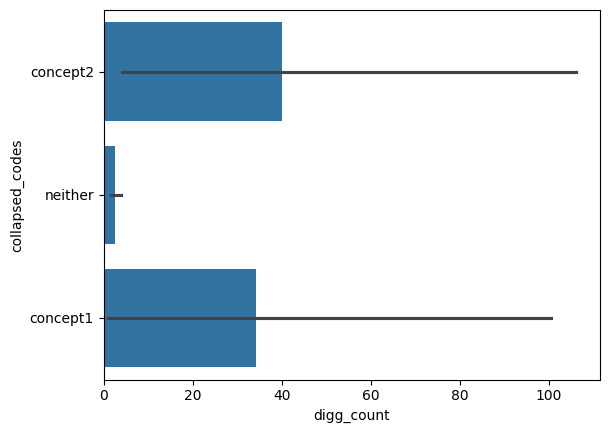

In [87]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='digg_count')

#### What comments got the most replies?

<Axes: xlabel='reply_comment_total', ylabel='collapsed_codes'>

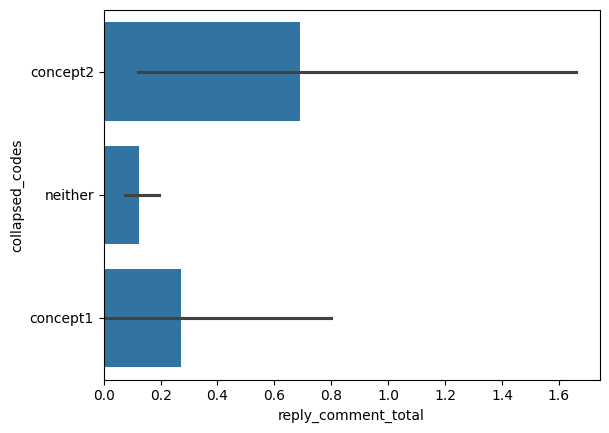

In [88]:
sns.barplot(data=final_coded_data, y='collapsed_codes', x='reply_comment_total')

#### What types of comments are shown more?
This is a visibility metric: higher scores means higher visibility in the comment section

In [90]:
import ast
final_coded_data['sort_extra_score_loaded'] = final_coded_data.sort_extra_score.apply(lambda x: ast.literal_eval(x))
final_coded_data['show_more'] = final_coded_data.sort_extra_score_loaded.apply(lambda x: float(dict(x)['show_more_score']))
sns.barplot(data=final_coded_data, y='collapsed_codes', x='show_more')

ValueError: malformed node or string: nan

#### Are there differences in age between commenters?

In [91]:
final_coded_data['users_loaded'] = final_coded_data.user.apply(lambda x: ast.literal_eval(x))
final_coded_data['age'] = final_coded_data.users_loaded.apply(
    lambda x: x['predicted_age_group'] if isinstance(x, dict) and 'predicted_age_group' in x else None
)

def reduce(x):
    try:
        return float(x)
    except:
        return float('nan')
final_coded_data['age'] = final_coded_data.age.apply(reduce)


<Axes: xlabel='age', ylabel='collapsed_codes'>

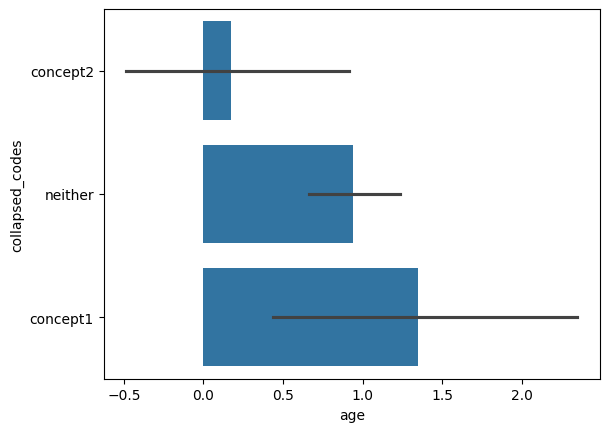

In [92]:
sns.barplot(data=final_coded_data.dropna(subset='age'), y='collapsed_codes', x='age')

- group -1 = 13-17
- group 1 = 18-24
- group 2 = 25-34
- group 3 = 35-44
- group 4 = 45-54
- group 5 = 55+

#### Use an LLM to create one more visualization or analysis
You might need to inspect your data!

## Does the code assigned predict how recently a comment was posted?

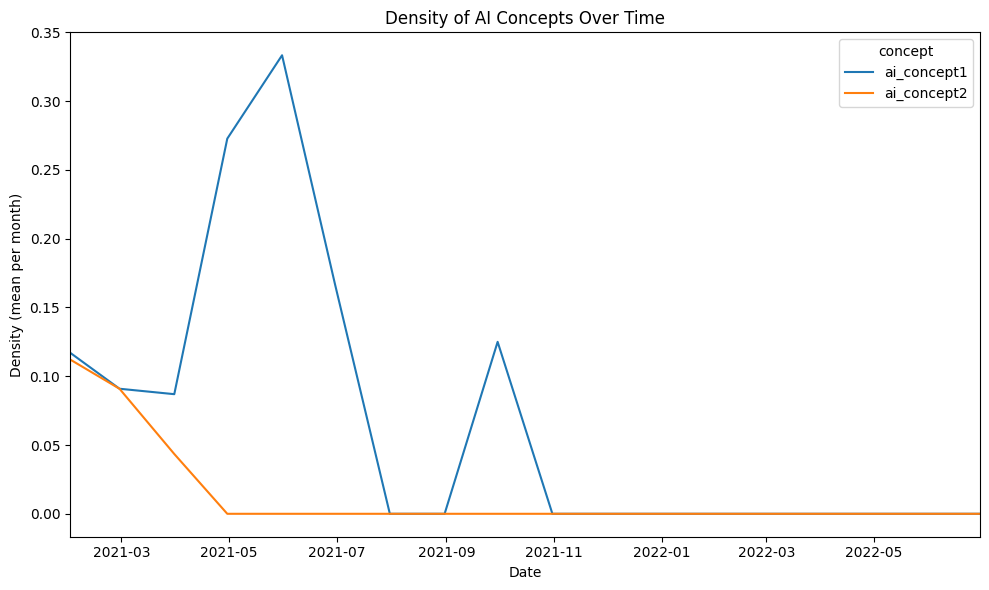

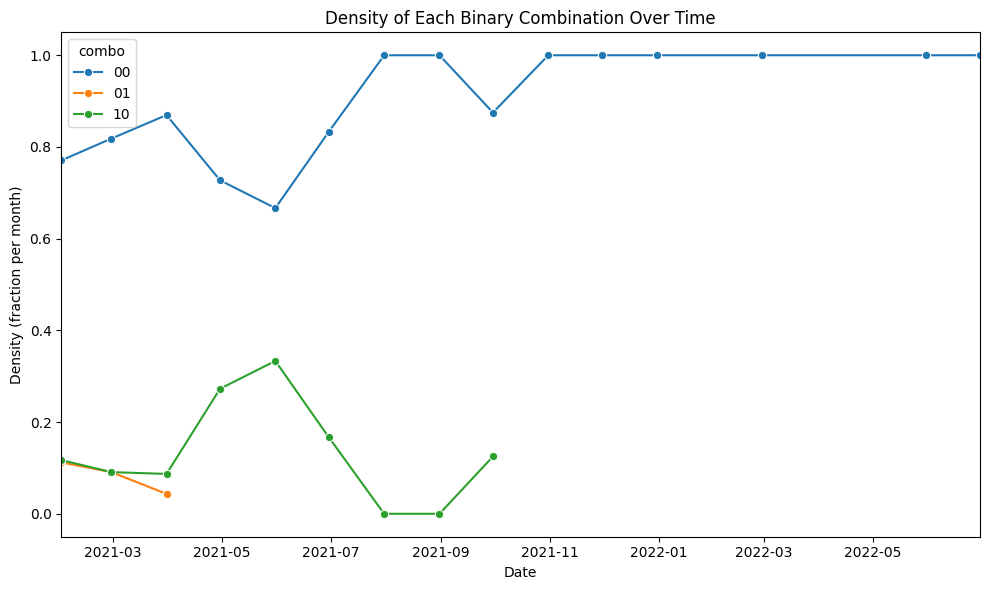

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = final_coded_data.copy()
df['create_time'] = pd.to_datetime(df['create_time'], unit='s')

# Drop time outliers
low, high = df['create_time'].quantile([0.01, 0.99])
df = df[(df['create_time'] >= low) & (df['create_time'] <= high)]

density = (
    df.set_index('create_time')
      .resample('ME')[['ai_concept1', 'ai_concept2']]
      .mean()
      .reset_index()
)

density_melted = density.melt(
    id_vars='create_time',
    value_vars=['ai_concept1', 'ai_concept2'],
    var_name='concept',
    value_name='density'
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=density_melted, x='create_time', y='density', hue='concept')
plt.title("Density of AI Concepts Over Time")
plt.xlabel("Date")
plt.ylabel("Density (mean per month)")
plt.xlim(density['create_time'].min(), density['create_time'].max())
plt.tight_layout()
plt.savefig("./graph1.png")
plt.show()

# 2nd plot
df['combo'] = df['ai_concept1'].astype(str) + df['ai_concept2'].astype(str)

combo_density = (
    df.set_index('create_time')
      .groupby('combo')
      .resample('ME')
      .size()
      .reset_index(name='count')
)

daily_total = combo_density.groupby('create_time')['count'].transform('sum')
combo_density['density'] = combo_density['count'] / daily_total

plt.figure(figsize=(10, 6))
sns.lineplot(data=combo_density, x='create_time', y='density', hue='combo', marker='o')
plt.title("Density of Each Binary Combination Over Time")
plt.xlabel("Date")
plt.ylabel("Density (fraction per month)")
plt.xlim(combo_density['create_time'].min(), combo_density['create_time'].max())
plt.tight_layout()
plt.savefig("./graph2.png")
plt.show()


## What does it all mean??
Spend 2-3 paragraphs reflecting on the results from your analysis. What are the implications of this work?